## Problem Statement

How does geography correlate with other data attributes, such as provider density, provider specialties, or costs?

In [170]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## Import Libraries

In [171]:
import pandas as pd
import matplotlib.pyplot as plt

## Importing and Cleaning Dataset

### Medicare Provider Dataset

This dataset contains the overall drug utilization (claims, 30-day standardized fill counts and day’s supply), drug costs, and beneficiary counts organized by National Provider Identifier. Drug utilization, drug costs, and beneficiary counts are also included for each of the following sub group classifications:
* Beneficiaries age 65 and older
* Brand drugs, generic drugs, and other drugs
* Medicare Advantage Prescription Drug (MAPD) and stand-alone Prescription Drug Plans (PDP)
* Low-income subsidy (LIS) and no low-income subsidy (nonLIS)
* Opioids, long-actingopioids, antibiotics, and antipsychoticsin the elderly

In [ ]:
provider = pd.read_csv('PartD_Prescriber_PUF_NPI_17.txt', sep='\t')
provider.head()

In [42]:
non_us = provider[provider.nppes_provider_country != 'US']
print(len(non_us))
non_us[['nppes_provider_zip4', 'nppes_provider_city', 'nppes_provider_state', 'nppes_provider_country']].head()

166


,nppes_provider_zip4,nppes_provider_city,nppes_provider_state,nppes_provider_country
3675,NaN,WATERLOO,ZZ,CA
12358,3.0,SHANGHAI,ZZ,CN
19753,NaN,FPO AE,ZZ,ES
22320,NaN,APO,ZZ,DE
24980,NaN,LANCASTER,ZZ,AA


In [172]:
us_provider = []

for chunk in pd.read_csv('PartD_Prescriber_PUF_NPI_17.txt', sep='\t', chunksize = 20000):
    us_provider.append(chunk[chunk.nppes_provider_country == 'US'][['npi', 'nppes_provider_gender',
       'nppes_entity_code', 'nppes_provider_city','nppes_provider_state', 'specialty_description', 'total_claim_count',
       'total_30_day_fill_count', 'total_drug_cost', 'total_day_supply','bene_count', 'average_age_of_beneficiaries', 
       'beneficiary_age_less_65_count', 'beneficiary_age_65_74_count', 'beneficiary_age_75_84_count',
       'beneficiary_age_greater_84_count', 'beneficiary_female_count', 'beneficiary_male_count', 'beneficiary_race_white_count',
       'beneficiary_race_black_count', 'beneficiary_race_asian_pi_count','beneficiary_race_hispanic_count', 'beneficiary_race_nat_ind_count',
       'beneficiary_race_other_count', 'beneficiary_nondual_count', 'beneficiary_dual_count', 'beneficiary_average_risk_score']])
us_provider = pd.concat(us_provider)

There seems to be 166 non-US providers included in this dataset. However, for this analysis I will focus on the overall metrics for beneficiaries and their demographics only for providers in the US. 

In [145]:
# Checking the data
us_provider = provider[provider.nppes_provider_country == 'US'][['npi', 'nppes_provider_gender',
       'nppes_entity_code', 'nppes_provider_city','nppes_provider_state', 'specialty_description', 'total_claim_count',
       'total_30_day_fill_count', 'total_drug_cost', 'total_day_supply','bene_count', 'average_age_of_beneficiaries', 
       'beneficiary_age_less_65_count', 'beneficiary_age_65_74_count', 'beneficiary_age_75_84_count',
       'beneficiary_age_greater_84_count', 'beneficiary_female_count', 'beneficiary_male_count', 'beneficiary_race_white_count',
       'beneficiary_race_black_count', 'beneficiary_race_asian_pi_count','beneficiary_race_hispanic_count', 'beneficiary_race_nat_ind_count',
       'beneficiary_race_other_count', 'beneficiary_nondual_count', 'beneficiary_dual_count', 'beneficiary_average_risk_score']]
us_provider.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1162732 entries, 0 to 1162897
Data columns (total 27 columns):
npi                                 1162732 non-null int64
nppes_provider_gender               1162729 non-null object
nppes_entity_code                   1162732 non-null object
nppes_provider_city                 1162732 non-null object
nppes_provider_state                1162732 non-null object
specialty_description               1162732 non-null object
total_claim_count                   1162732 non-null int64
total_30_day_fill_count             1162732 non-null float64
total_drug_cost                     1162732 non-null float64
total_day_supply                    1162732 non-null int64
bene_count                          1030928 non-null float64
average_age_of_beneficiaries        1030928 non-null float64
beneficiary_age_less_65_count       645242 non-null float64
beneficiary_age_65_74_count         540060 non-null float64
beneficiary_age_75_84_count         361481 non

### Filling in Missing Values

3 of the providers in the dataset are organization; therefore, it makes sense that the 'nppes_provider_gender' is missing 3 values.

Most columns have null values because values fewer than 11 are suppressed and are indicated by a blank for privacy purposes. (See https://www.cms.gov/Research-Statistics-Data-and-Systems/Statistics-Trends-and-Reports/Medicare-Provider-Charge-Data/Downloads/Prescriber_Methods.pdf) 

Not treating these values will underestimate the true value; therefore, I will fill these suppressed values with 5. 

In [173]:
suppressed_cols = ['bene_count', 'beneficiary_age_less_65_count',
       'beneficiary_age_65_74_count', 'beneficiary_age_75_84_count',
       'beneficiary_age_greater_84_count', 'beneficiary_female_count',
       'beneficiary_male_count', 'beneficiary_race_white_count',
       'beneficiary_race_black_count', 'beneficiary_race_asian_pi_count',
       'beneficiary_race_hispanic_count', 'beneficiary_race_nat_ind_count',
       'beneficiary_race_other_count', 'beneficiary_nondual_count',
       'beneficiary_dual_count']

us_provider[suppressed_cols] = us_provider[suppressed_cols].fillna(5)

As illustrated by the boxplots below of the last 2 columns, the distributions tend to be skewed. I will fill the missing values with the median since it best represents the central value.

In [92]:
us_provider.columns[us_provider.isnull().any()][1:]

Index(['average_age_of_beneficiaries', 'beneficiary_average_risk_score'], dtype='object')

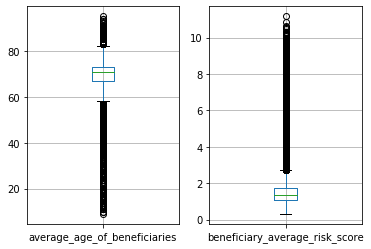

In [118]:
f, (ax1, ax2) = plt.subplots(1, 2)
us_provider.boxplot('average_age_of_beneficiaries', ax = ax1)
us_provider.boxplot('beneficiary_average_risk_score', ax = ax2)
plt.show()

In [174]:
avg_cols = ['average_age_of_beneficiaries', 'beneficiary_average_risk_score']
for col in avg_cols:
    us_provider[col] = us_provider[col].fillna(us_provider[col].median())

In [176]:
dtypes = us_provider.dtypes
dtypes_col = dtypes.index
dtypes_type = [i.name for i in dtypes.values]
column_types = dict(zip(dtypes_col, dtypes_type))
column_types = {key:'category' if value == 'object' else value for key, value in column_types.items()}

us_provider = us_provider.astype(column_types)
us_provider.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1162732 entries, 0 to 1162897
Data columns (total 27 columns):
npi                                 1162732 non-null int64
nppes_provider_gender               1162729 non-null category
nppes_entity_code                   1162732 non-null category
nppes_provider_city                 1162732 non-null category
nppes_provider_state                1162732 non-null category
specialty_description               1162732 non-null category
total_claim_count                   1162732 non-null int64
total_30_day_fill_count             1162732 non-null float64
total_drug_cost                     1162732 non-null float64
total_day_supply                    1162732 non-null int64
bene_count                          1162732 non-null float64
average_age_of_beneficiaries        1162732 non-null float64
beneficiary_age_less_65_count       1162732 non-null float64
beneficiary_age_65_74_count         1162732 non-null float64
beneficiary_age_75_84_count       

All the appropriate columns have now been filled in! To save memory space, object variables have been converted to categorical variables.

## US City Latitude Longitude Dataset

To aid with geocoding the providers, I have found a dataset that has the latitude and longitude for US Cities. 

(Source: https://public.opendatasoft.com/explore/dataset/us-zip-code-latitude-and-longitude/table/)

In [177]:
us_city = pd.read_csv('us-zip-code-latitude-and-longitude.csv', sep = ';')
us_city = us_city[['City', 'State', 'Latitude', 'Longitude']]
us_city.head()

,City,State,Latitude,Longitude
0,Cove,AR,34.398483,-94.39398
1,Edgemont,AR,35.624351,-92.16056
2,Sherburn,MN,43.660847,-94.74357
3,Lamont,MI,43.010337,-85.89754
4,Richland,IA,41.194129,-91.98027


In [179]:
us_city.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43191 entries, 0 to 43190
Data columns (total 4 columns):
City         43191 non-null object
State        43191 non-null object
Latitude     43191 non-null float64
Longitude    43191 non-null float64
dtypes: float64(2), object(2)
memory usage: 1.3+ MB


I will merge the latitude and longitude coordinates via city name and state name. The case of the name must be the same in order for the datasets to match. 

In [178]:
us_provider['nppes_provider_city'] = us_provider.nppes_provider_city.str.title()
geo_provider = pd.merge(us_provider, us_city, how = 'left', left_on = ['nppes_provider_city'], right_on = ['City'])
geo_provider.info()

MemoryError: 